In [7]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt


class CircularTrackEnv(gym.Env):
    metadata = {"render_modes": []}

    def __init__(self):
        super().__init__()

        self.R_in = 8.0
        self.R_out = 12.0
        self.R_mid = 10.0

        self.dt = 0.1
        self.L = 2.5
        self.v_max = 10.0

        self.k_p = 10.0
        self.k_t = 1.0
        self.k_r = 2.0
        self.k_v = 0.1
        self.k_o = 100.0

        self.action_space = spaces.Box(
            low=np.array([-1.0, -np.pi / 2]),
            high=np.array([1.0, np.pi / 2]),
            dtype=np.float32,
        )

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(5,),
            dtype=np.float32,
        )

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.x = self.R_mid
        self.y = 0.0
        self.v = 2.0
        self.theta = np.pi / 2
        self.phi_prev = np.arctan2(self.y, self.x)
        self.phi_total = 0.0
        return self._get_obs(), {}

    def _get_obs(self):
        omega = self.v / self.L
        return np.array([self.x, self.y, self.v, self.theta, omega], dtype=np.float32)

    def step(self, action):
        a, delta = action

        self.v = np.clip(self.v + a * self.dt, 0.0, self.v_max)
        self.theta += (self.v / self.L) * np.tan(delta) * self.dt
        self.x += self.v * np.cos(self.theta) * self.dt
        self.y += self.v * np.sin(self.theta) * self.dt

        r = np.sqrt(self.x**2 + self.y**2)
        phi = np.arctan2(self.y, self.x)

        dphi = phi - self.phi_prev
        if dphi < -np.pi:
            dphi += 2 * np.pi
        elif dphi > np.pi:
            dphi -= 2 * np.pi

        self.phi_prev = phi
        self.phi_total += max(dphi, 0.0)

        r_progress = self.k_p * dphi
        r_time = -self.k_t * self.dt
        r_radial = -self.k_r * abs(r - self.R_mid)
        r_speed = self.k_v * self.v

        reward = r_progress + r_time + r_radial + r_speed

        terminated = False

        if r < self.R_in or r > self.R_out:
            reward -= self.k_o
            terminated = True

        if self.phi_total >= 2 * np.pi:
            terminated = True

        return self._get_obs(), reward, terminated, False, {}

In [ ]:
env = CircularTrackEnv()

model = PPO(
    "MlpPolicy",
    env,
    learning_rate=3e-4,
    gamma=0.99,
    n_steps=2048,
    batch_size=64,
    verbose=1,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
model.learn(total_timesteps=200_000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51.2     |
|    ep_rew_mean     | -172     |
| time/              |          |
|    fps             | 1599     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 46.2         |
|    ep_rew_mean          | -168         |
| time/                   |              |
|    fps                  | 1098         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0041662776 |
|    clip_fraction        | 0.0477       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.86        |
|    explained_variance   | -0.00186     |
|    learning_r

In [ ]:
obs, _ = env.reset()
xs, ys, rewards = [], [], []

for _ in range(1000):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = env.step(action)
    xs.append(env.x)
    ys.append(env.y)
    rewards.append(reward)
    if done:
        break

print(f"Steps: {len(xs)}")
print(f"Total reward: {np.sum(rewards):.2f}")
print(f"Mean reward per step: {np.mean(rewards):.2f}")

Steps: 71
Total reward: -107.91
Mean reward per step: -1.52


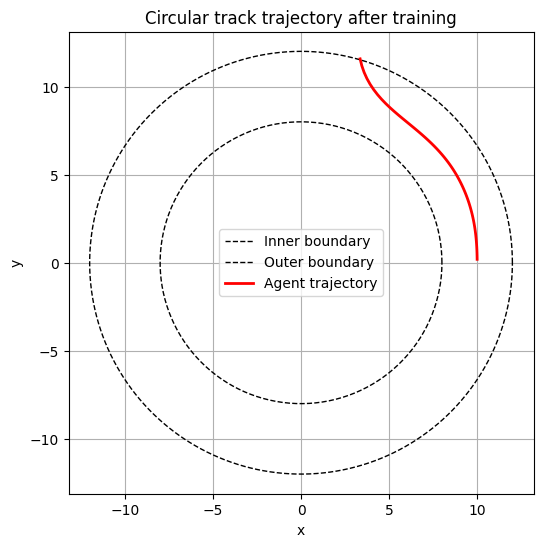

In [ ]:
theta = np.linspace(0, 2 * np.pi, 400)

inner_x = env.R_in * np.cos(theta)
inner_y = env.R_in * np.sin(theta)
outer_x = env.R_out * np.cos(theta)
outer_y = env.R_out * np.sin(theta)

plt.figure(figsize=(6, 6))
plt.plot(inner_x, inner_y, "k--", linewidth=1, label="Inner boundary")
plt.plot(outer_x, outer_y, "k--", linewidth=1, label="Outer boundary")
plt.plot(xs, ys, "r", linewidth=2, label="Agent trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Circular track trajectory after training")
plt.axis("equal")
plt.legend()
plt.grid(True)
plt.show()